In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import math
from skimage.io import imread
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

print(os.listdir("../input"))

['sample_submission_v2.csv', 'test_v2', 'train_v2', 'train_ship_segmentations_v2.csv']


In [3]:
TRAIN = "../input/train_v2/"
TEST = "../input/test_v2/"
SEG = "../input/train_ship_segmentations_v2.csv"
NB_EPOCHS = 30
BATCH_SIZE = 8

In [4]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [5]:
df = pd.read_csv(SEG, header=0, names=["img_id", "mask_encoded"])

In [6]:
df.head()

,img_id,mask_encoded
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
df.dropna(inplace=True)

In [8]:
df.head()

,img_id,mask_encoded
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


In [9]:
agg_df = df.groupby("img_id").agg({"mask_encoded": (lambda x: list(x))}).reset_index()
agg_df["nb_ship"] = agg_df["mask_encoded"].progress_apply(lambda masks: len([mask for mask in masks if str(mask)!="nan"]))
agg_df.rename(columns={"mask_encoded":"masks"}, inplace=True)

100%|██████████| 42556/42556 [00:00<00:00, 524123.27it/s]


In [10]:
agg_df.head()

,img_id,masks,nb_ship
0,000155de5.jpg,[264661 17 265429 33 266197 33 266965 33 26773...,1
1,000194a2d.jpg,[360486 1 361252 4 362019 5 362785 8 363552 10...,5
2,00021ddc3.jpg,[108287 1 109054 3 109821 4 110588 5 111356 5 ...,9
3,0002756f7.jpg,[255784 2 256552 4 257319 7 258087 9 258854 12...,2
4,00031f145.jpg,[340363 1 341129 4 341896 6 342663 7 343429 10...,1


In [11]:
def get_mask_img(masks):
    mask_img = np.zeros((768, 768), np.int16)
    for mask in masks:
        if str(mask) != "nan":
            mask_img += rle_decode(mask)
    return np.expand_dims(mask_img, axis=-1)

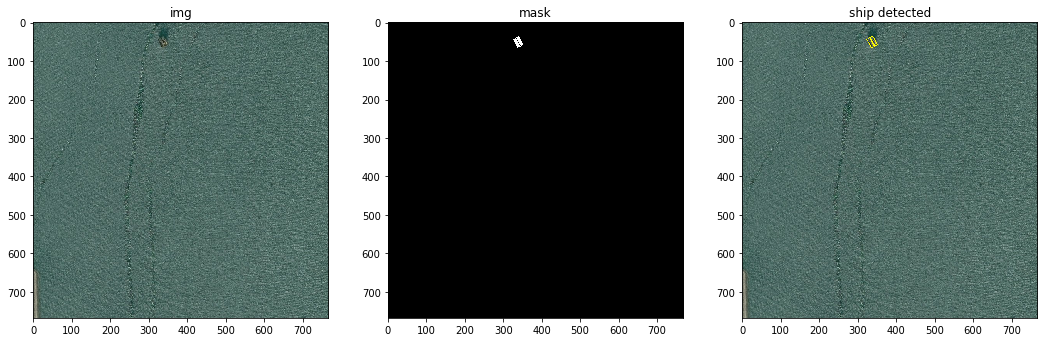

In [12]:
idx = 3
img = imread(TRAIN+agg_df["img_id"][idx])
mask = get_mask_img(agg_df["masks"][idx])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img)
axes[0].set_title("img")
axes[1].imshow(mask[:, :, 0])
axes[1].set_title("mask")
axes[2].imshow(mark_boundaries(img, mask[:, :, 0], mode="thick"))
axes[2].set_title("ship detected")
plt.show()

In [13]:
from keras import models, layers

def get_unet(input_shape):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = layers.UpSampling2D((2, 2)) (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = layers.UpSampling2D((2, 2)) (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = layers.UpSampling2D((2, 2)) (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = layers.UpSampling2D((2, 2)) (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

    unet = models.Model(inputs=[inputs], outputs=[outputs])
    return unet

Using TensorFlow backend.


In [14]:
def image_generator(df, batch_size, mode="train", aug=None):
    img_ids = list(df["img_id"])
    np.random.shuffle(img_ids)
    images = []
    masks = []
    while True:
        for img_id in img_ids:
            image = imread(TRAIN+img_id)
            mask = get_mask_img(df.loc[df["img_id"] == img_id]["masks"].item())
            images.append(image)
            masks.append(mask)
            if len(images) >= batch_size:
                if aug is not None:
                    seed = np.random.randint(2**32 - 1)
                    images = next(aug.flow(np.array(images), seed=seed, batch_size=batch_size))/255.0
                    masks = next(aug.flow(np.array(masks), seed=seed, batch_size=batch_size))
                yield (np.array(images), np.array(masks))
                images = []
                masks = []

In [15]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2,
                         height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, vertical_flip=True,
                         fill_mode="reflect")

In [16]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(agg_df, test_size = 0.1)
print(train_df.shape)
print(valid_df.shape)

(38300, 3)
(4256, 3)


In [17]:
train_gen = image_generator(train_df, BATCH_SIZE, aug=aug)
valid_gen = image_generator(valid_df, BATCH_SIZE)

In [18]:
import keras.backend as K
from keras.optimizers import adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('unet_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [20]:
unet_model = get_unet((768, 768, 3))
unet_model.compile(optimizer=adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
MAX_TRAIN_STEPS = 500
steps_per_epoch = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
validation_steps = min(MAX_TRAIN_STEPS, valid_df.shape[0]//BATCH_SIZE)
H = unet_model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=valid_gen,
                             validation_steps=validation_steps,
                             epochs=NB_EPOCHS,
                             verbose=1,
                             workers=1,
                             callbacks=callbacks_list)

Epoch 1/30
500/500 [==============================] - 269s 538ms/step - loss: -0.2975 - dice_coef: 0.2978 - binary_accuracy: 0.9685 - true_positive_rate: 0.5585 - val_loss: -0.3954 - val_dice_coef: 0.3958 - val_binary_accuracy: 0.9710 - val_true_positive_rate: 0.7573

Epoch 00001: val_dice_coef improved from -inf to 0.39578, saving model to unet_model_weights.best.hdf5
Epoch 2/30
500/500 [==============================] - 269s 538ms/step - loss: -0.4018 - dice_coef: 0.4020 - binary_accuracy: 0.9815 - true_positive_rate: 0.6505 - val_loss: -0.4365 - val_dice_coef: 0.4367 - val_binary_accuracy: 0.9840 - val_true_positive_rate: 0.6675

Epoch 00002: val_dice_coef improved from 0.39578 to 0.43674, saving model to unet_model_weights.best.hdf5
Epoch 3/30
500/500 [==============================] - 260s 521ms/step - loss: -0.4419 - dice_coef: 0.4421 - binary_accuracy: 0.9849 - true_positive_rate: 0.6680 - val_loss: -0.4530 - val_dice_coef: 0.4533 - val_binary_accuracy: 0.9798 - val_true_positiv

In [21]:
unet_model.load_weights(weight_path)

In [22]:
valid_x, valid_y = next(valid_gen)

In [23]:
pred_y = unet_model.predict(valid_x)

In [24]:
print(valid_x.shape)
print(valid_y.shape)
print(pred_y.shape)

(8, 768, 768, 3)
(8, 768, 768, 1)
(8, 768, 768, 1)


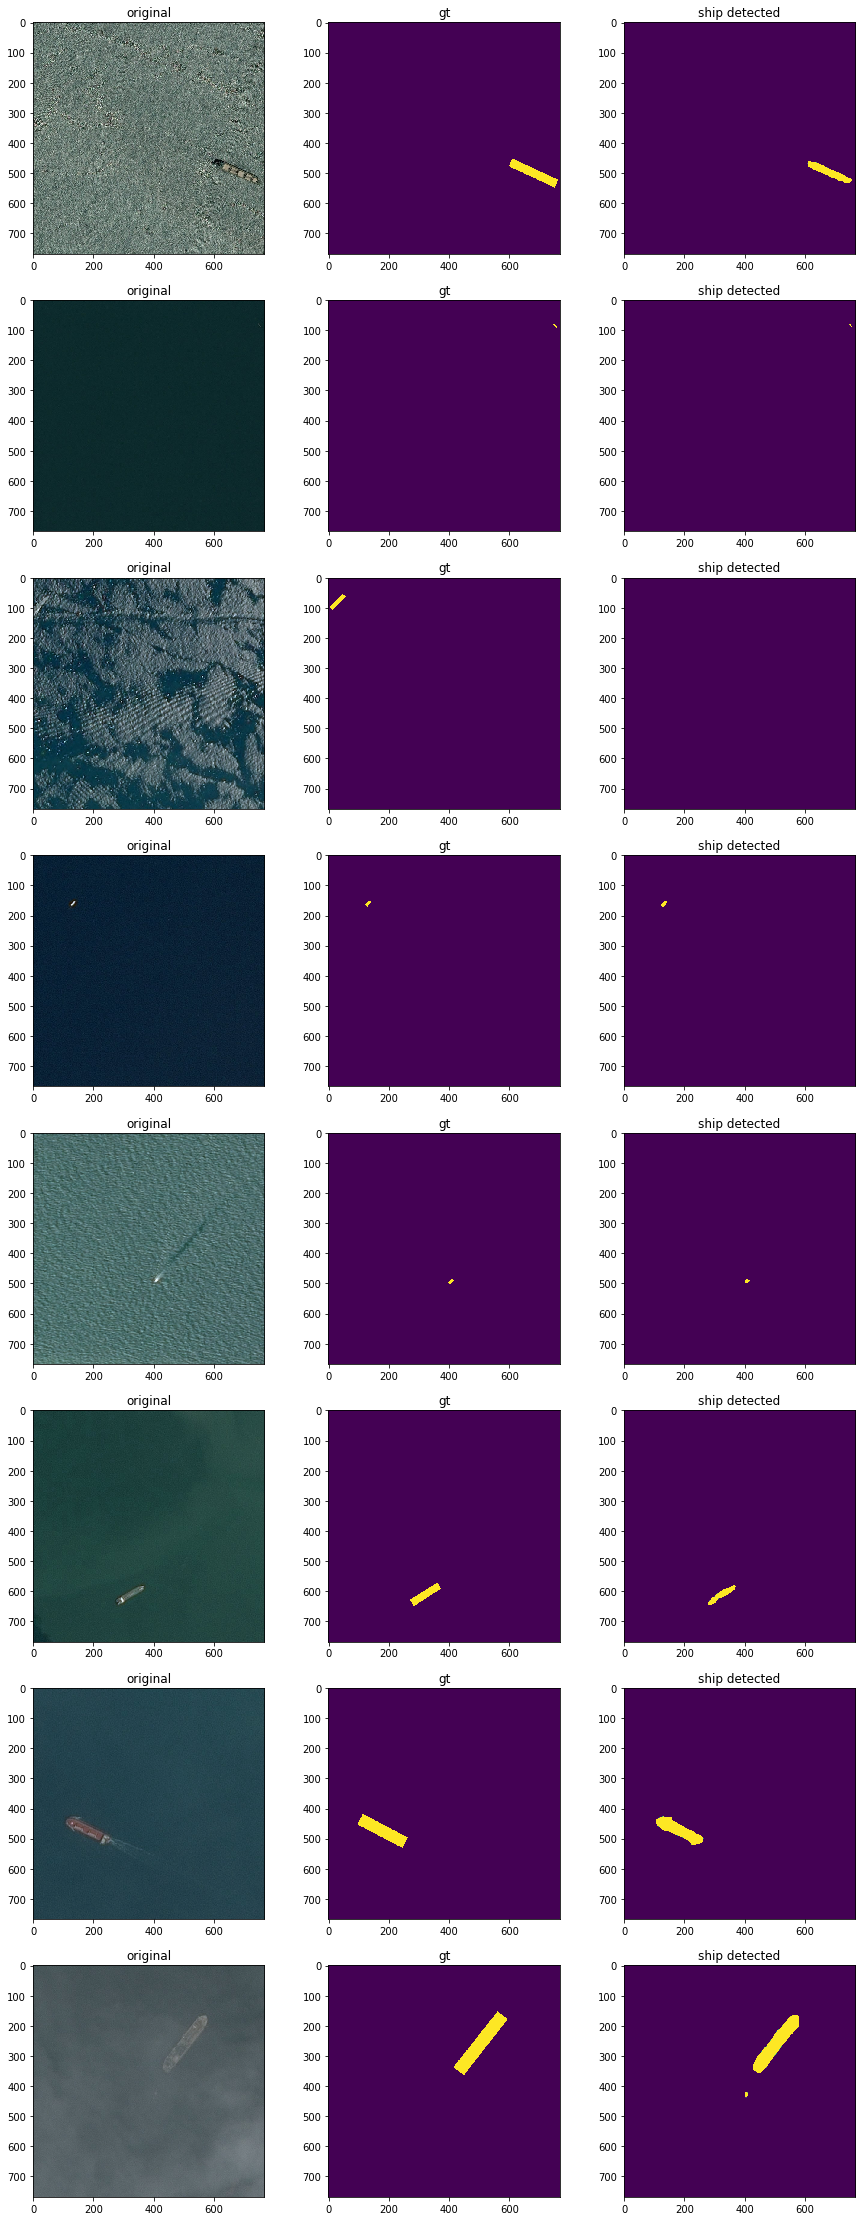

In [25]:
n = valid_x.shape[0]
fig, axes = plt.subplots(n, 3, figsize=(15, 5*n))
for i, (x, y, pred) in enumerate(zip(valid_x, valid_y, pred_y)):
    axes[i][0].imshow(x)
    axes[i][0].set_title("original")
    axes[i][1].imshow(y[:, :, 0])
    axes[i][1].set_title("gt")
    axes[i][2].imshow(pred[:, :, 0])
    axes[i][2].set_title("ship detected")
plt.show()